<H1>Stratégie Bollinger Trend Multicoin + VaR</H1>
Indicateurs: bande de Bollinger + moyenne mobile long terme<br>
Gestion du risque: Value at Risk (méthode paramétrique)<br>
SEG

In [1]:
# Modules standards
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import ccxt
import warnings
warnings.filterwarnings("ignore")

# Modules perso
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month, complete_multi_asset_backtest
from utilities.strategies import BollingerTrendMulti
from utilities.data_manager import ExchangeDataManager

<H2>Coins + paramètres</H2>

In [2]:
# Liste des coins à backtester avec la stratégie.
# Chaque coin peut avoir un paramètre et un poids différent
wallet_exposure = 0.05      # Taille des lots (0.1=10%)
bb_window = 100             # Fenêtre de la Bollinger
bb_std = 1                  # Déviation standard de la Bollinger
long_ma_window = 550        # Moyenne mobile long terme

params_coin = {
    "BTC/USDT": {"wallet_exposure": 0.1, "bb_window": bb_window, "bb_std": 2.2,"long_ma_window": long_ma_window},
    "ETH/USDT": {"wallet_exposure": 0.1, "bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    # Altcoin
    "AAVE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window,"bb_std": bb_std, "long_ma_window": long_ma_window},
    "ADA/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "APE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "APT/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "ATOM/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "AVAX/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "AXS/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "BNB/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "C98/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "CRV/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "DOGE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "DOT/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "DYDX/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "EGLD/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    "ETC/USDT": {"wallet_exposure": wallet_exposure,"bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    "FIL/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "FTM/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "GALA/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "GMT/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    "GRT/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "ICX/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "JASMY/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    "KNC/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "KSM/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    "LINK/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "LIT/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "LRC/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "MANA/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "MASK/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "MATIC/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "NEAR/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "ONE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "OP/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    "RDNT/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "ROSE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "SAND/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "SHIB/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "SOL/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "STG/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "WAVES/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    "WOO/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "XRP/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "YFI/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": 2.2, "long_ma_window": long_ma_window},
    "ZEC/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
}

pair_list = list(params_coin.keys())
exchange_name = "binance"
tf = '1h'
oldest_pair = "BTC/USDT"

# Nouvelle méthode de chargement des données avec data_manager.py (plus besoin de passer par Javascript)
exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df_list = {}
for pair in pair_list:
    df = exchange.load_data(pair, tf)
    df_list[pair] = df.loc[:]   # Dates des datas

print("Data load 100%")
# df_list[oldest_pair]

Data load 100%


<H2>Backtest</H2>

In [3]:
# Paramètres à modifier pour le backtest
initial_wallet = 1000
leverage = 1.5
max_var = 1                                 # max_var=1.5 indique que sur 1 heure, le maximum de perte sera de 1.5%
maker_fee, taker_fee = 0.00017, 0.00051     # Bitget
# maker_fee, taker_fee = 0.0003, 0.00012    # Binance

strat = BollingerTrendMulti(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin,
    type=["long","short"]
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=initial_wallet, leverage=leverage, max_var=max_var, 
                               maker_fee=maker_fee, taker_fee=taker_fee)

# Sections à afficher ou pas pour le backtest complet
df_trades, df_days = complete_multi_asset_backtest(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True
)

╒═════════════════════════════════╤══════════════════════════╕
│ Informations générales          │                          │
╞═════════════════════════════════╪══════════════════════════╡
│ Période                         │ 28.09.2017 -> 28.12.2023 │
│ Portefeuille initial            │ 1,000.00 $               │
│                                 │                          │
│ Portefeuille final              │ 4,038,302.02 $           │
│ Performance vs US dollar        │ 403,730.20 %             │
│ Pire Drawdown T|D               │ -58.61 % | -59.3 %       │
│ Moyenne journalière Drawdown    │ -10.8 %                  │
│ Buy and hold performance        │ 949.28 %                 │
│ Performance vs buy and hold     │ 38,386.25 %              │
│ Nombre total de trades          │ 8613                     │
│ Sharpe | Sortino | Calmar Ratio │ 2.41 | 4.69 | 2.56       │
│ Global Win rate                 │ 32.15 %                  │
│ Profit moyen                    │ 1.49 %             

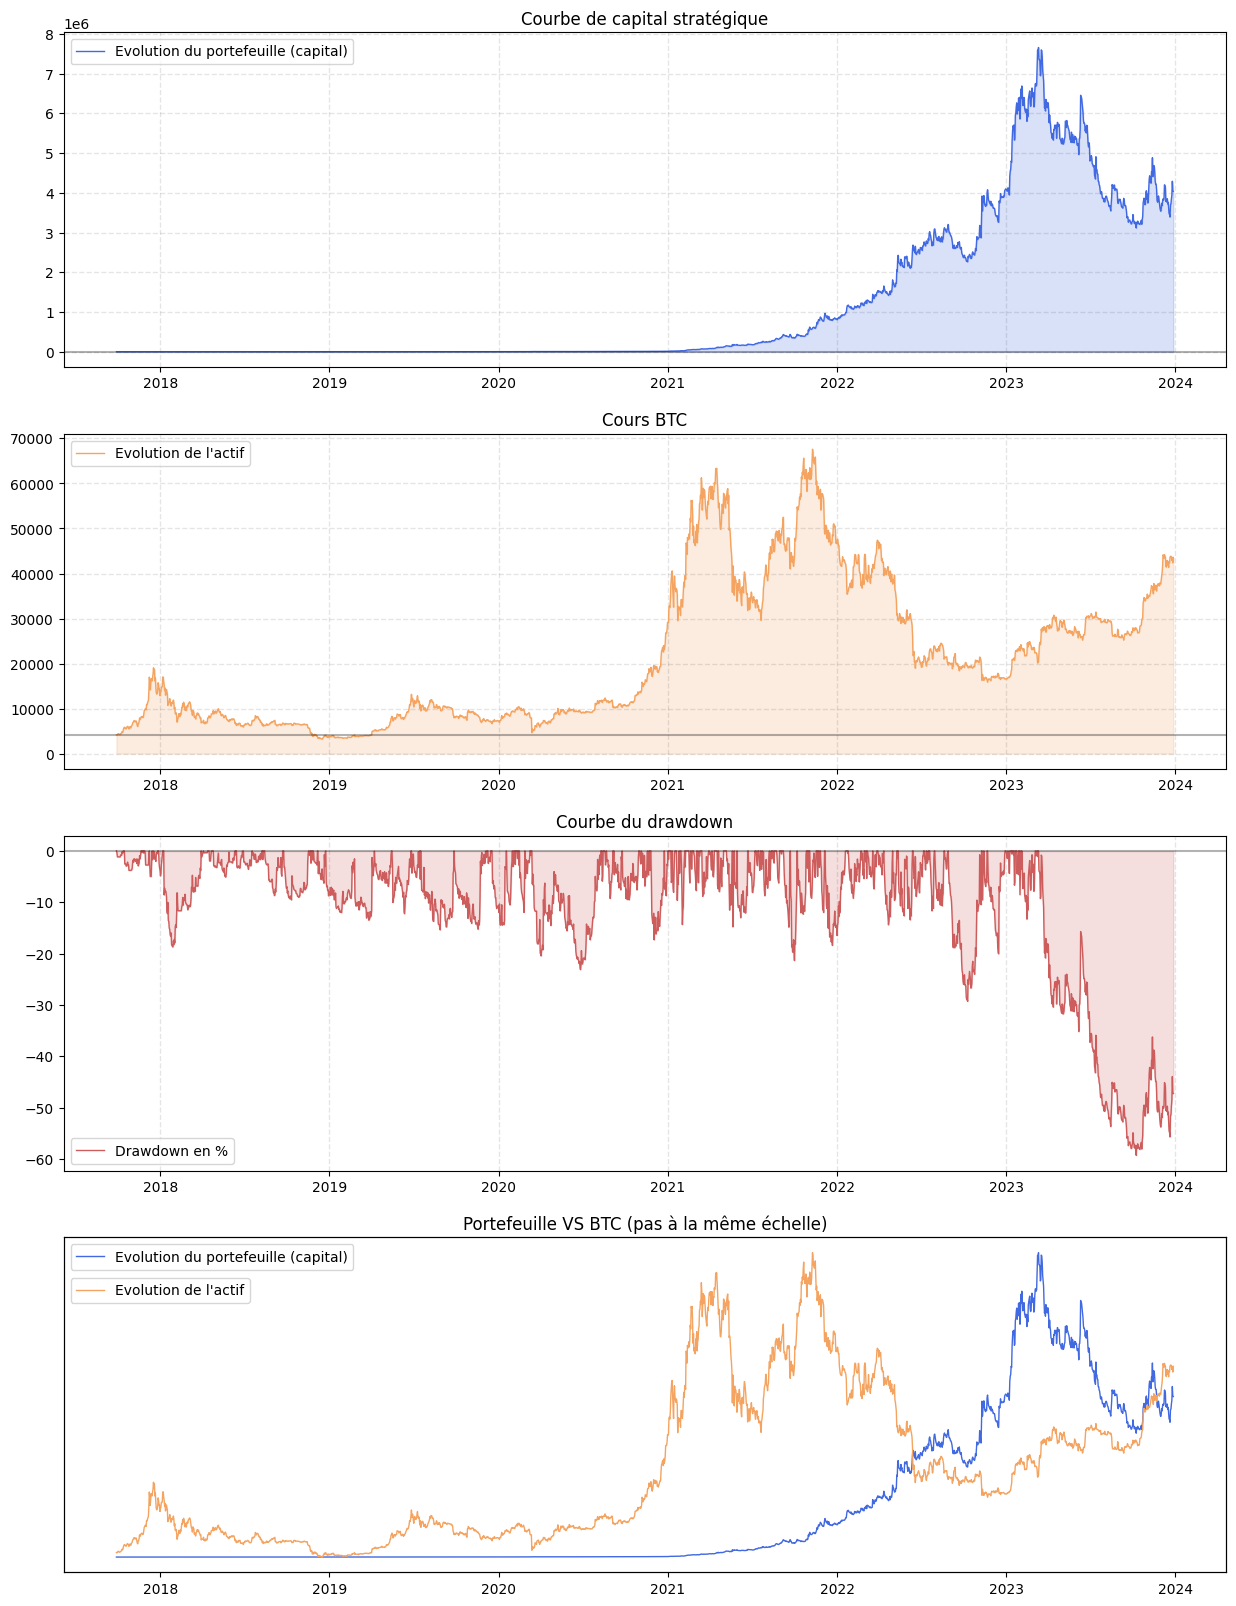

In [4]:
plot_wallet_vs_asset(df_days=df_days.loc[:], pair=oldest_pair)

<H2>Performance par mois et année</H2>

----- 2017 Performances cumulées: 19.18% --


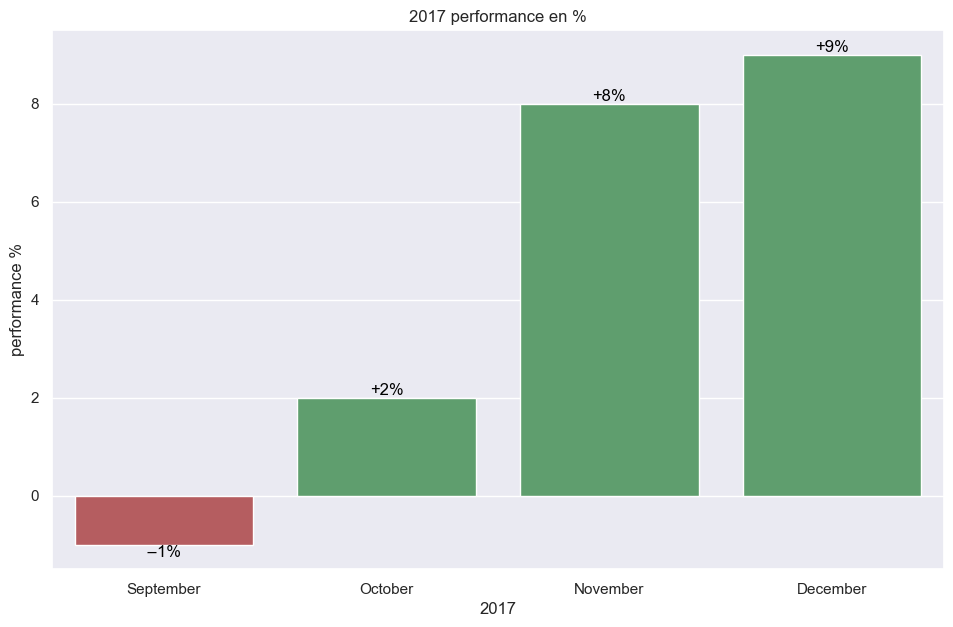

----- 2018 Performances cumulées: 91.64% --


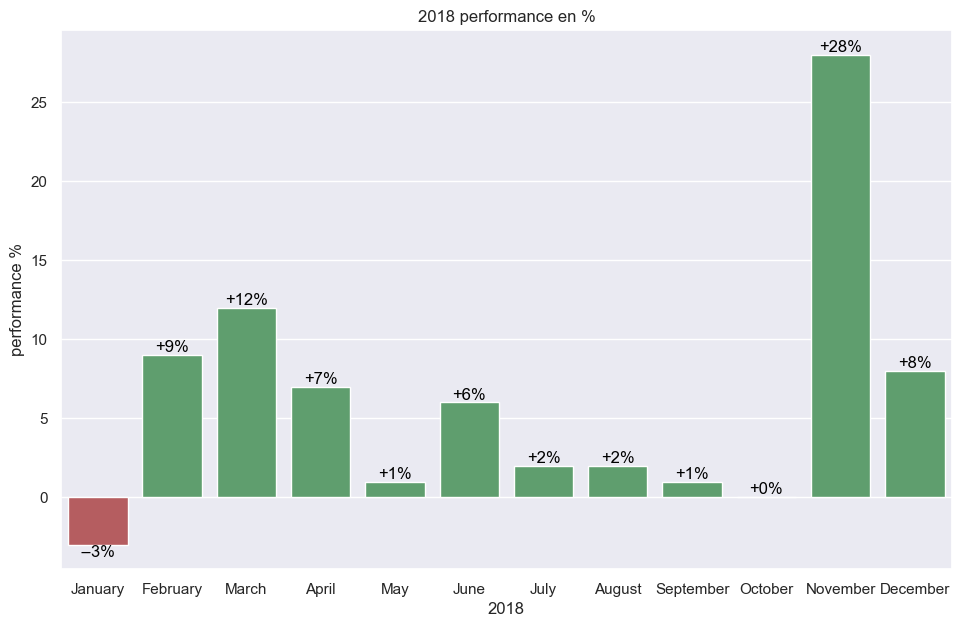

----- 2019 Performances cumulées: 48.96% --


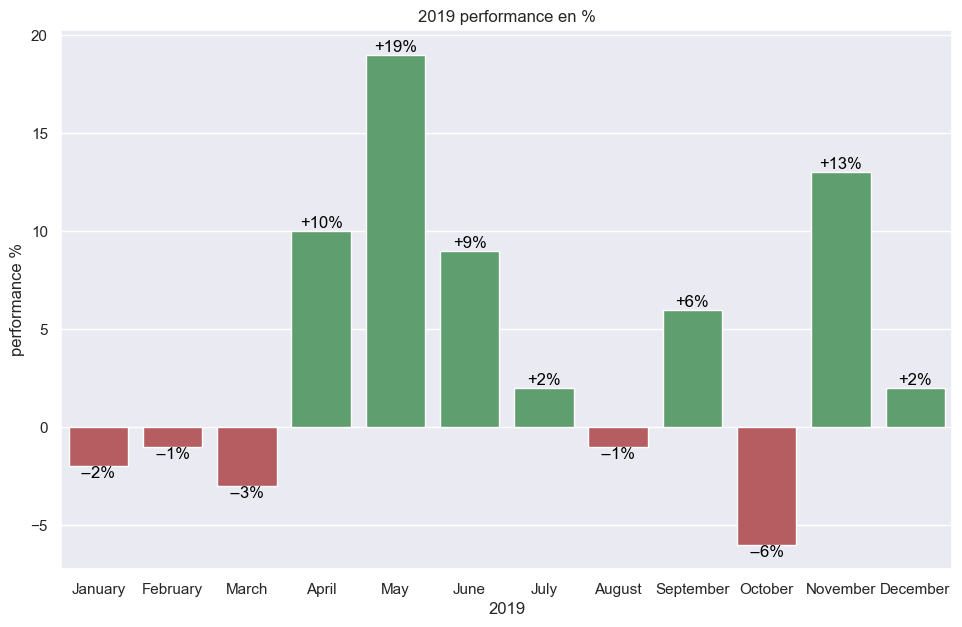

----- 2020 Performances cumulées: 321.37% --


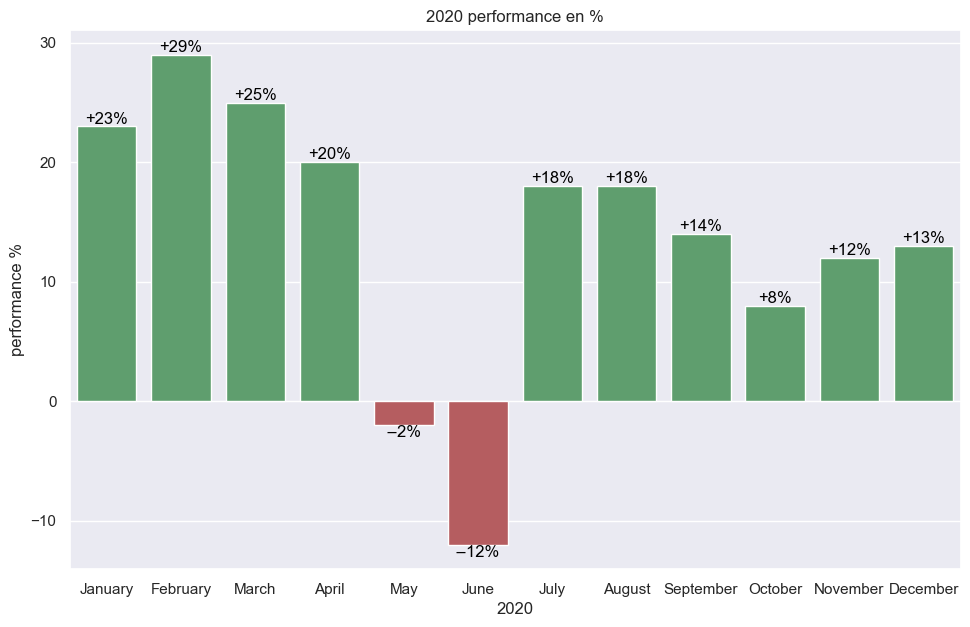

----- 2021 Performances cumulées: 5551.21% --


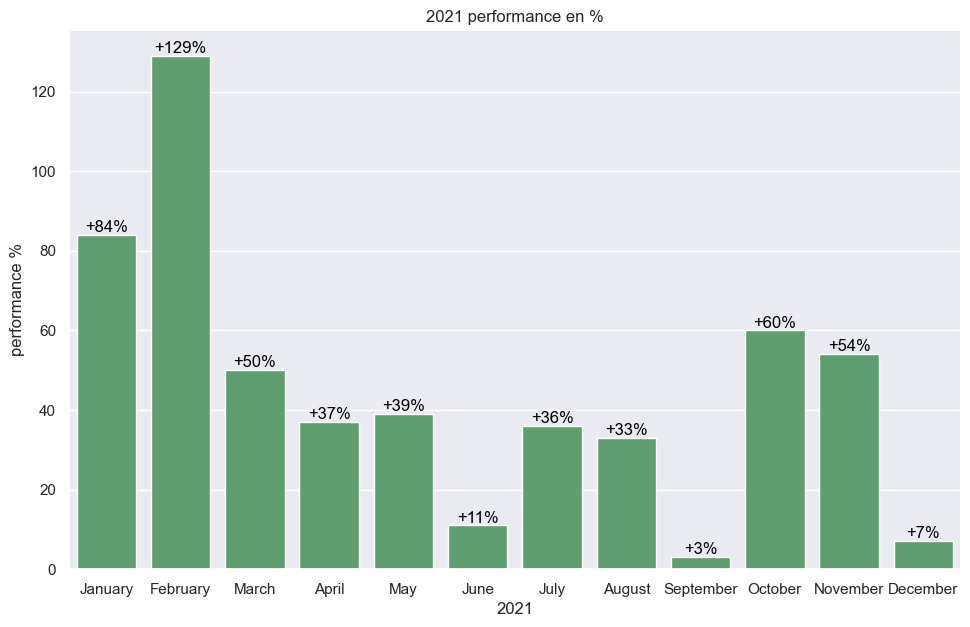

----- 2022 Performances cumulées: 406.37% --


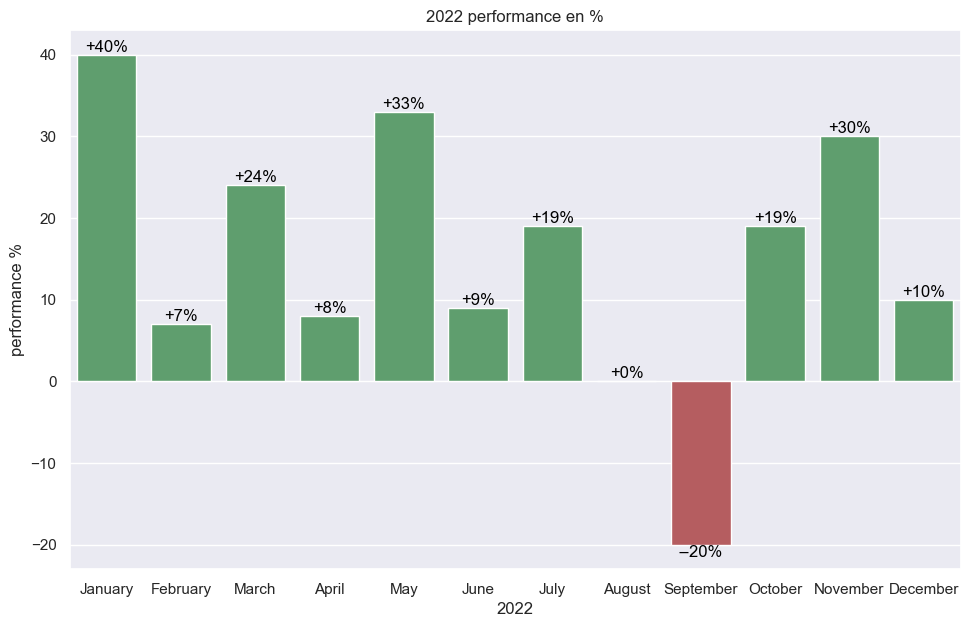

----- 2023 Performances cumulées: -1.32% --


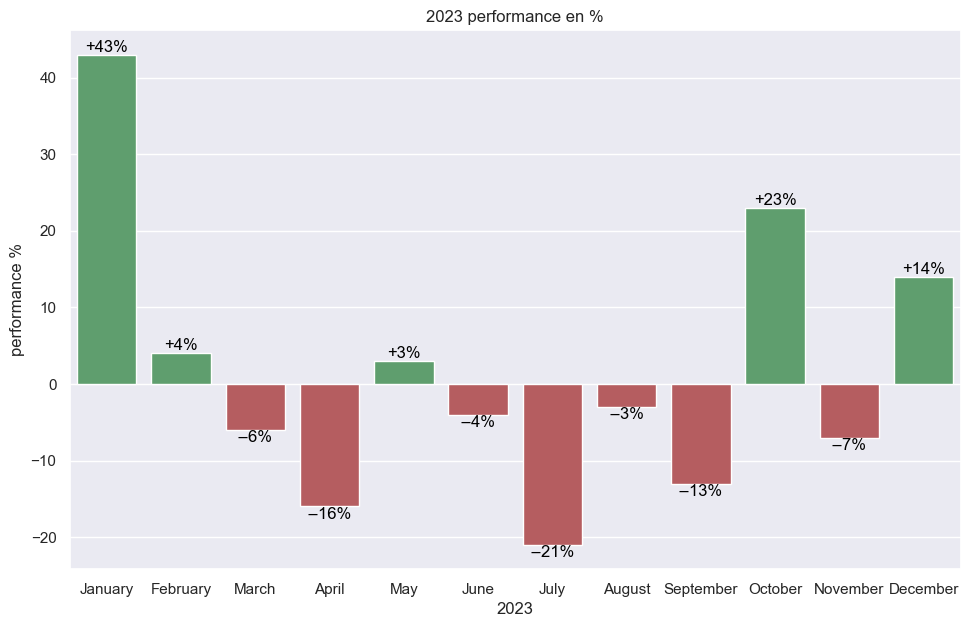

In [5]:
plot_bar_by_month(df_days=df_days.loc[:])

<H2>Courbe de surapprentissage</H2>

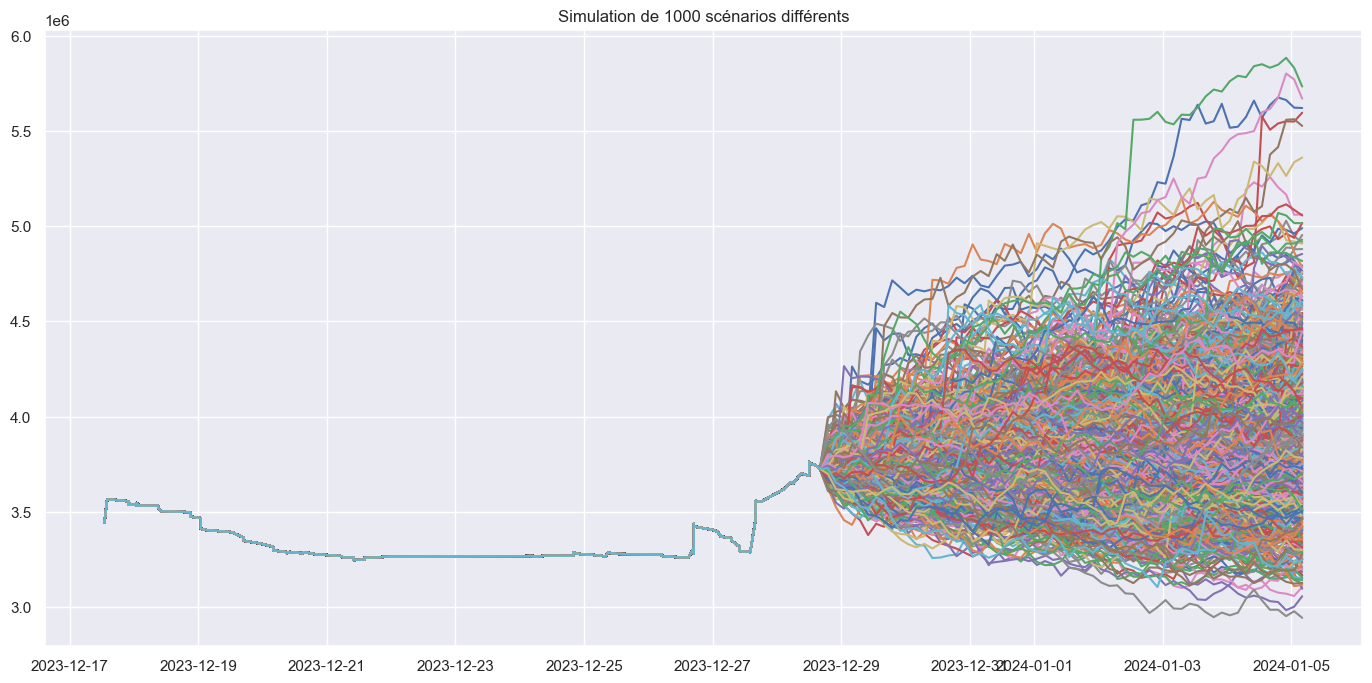

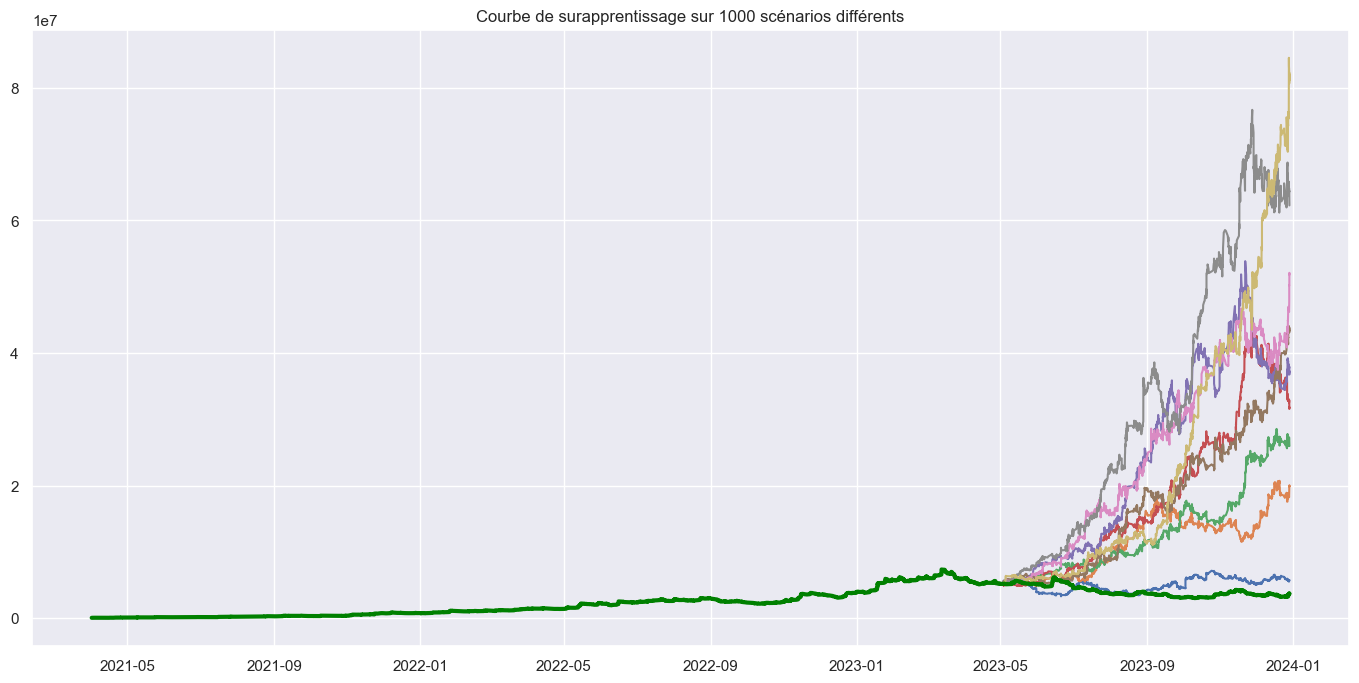

In [7]:
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation

# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=True
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
# Séparation des échantillons en train et en test - Méthode de Monte Carlo (Loi normale)
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2023-05-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)